<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/centralized_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib
!pip install --upgrade torch torchvision

## Import of libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Mounted at /content/drive


## Costants

In [4]:
BATCH_SIZE = 64

## Pre processing

In [5]:
# Define the transform to only convert the images to tensors (without normalization yet)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR-100 training dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=2)

# Initialize sums for calculating mean and std
mean = torch.zeros(3)
std = torch.zeros(3)

for images, _ in train_loader:
    # Compute mean and std for each channel
    mean += images.mean(dim=[0, 2, 3])  # Mean per channel (R, G, B)
    std += images.std(dim=[0, 2, 3])  # Std per channel (R, G, B)

mean /= len(train_loader)
std /= len(train_loader)

print("Mean: ", mean)
print("Std: ", std)


100%|██████████| 169M/169M [00:06<00:00, 27.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])


In [6]:
# Custom Cutout
"""class Cutout(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img)

        h, w = img.shape[:2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - self.size // 2, 0, h)
        y2 = np.clip(y + self.size // 2, 0, h)
        x1 = np.clip(x - self.size // 2, 0, w)
        x2 = np.clip(x + self.size // 2, 0, w)
        if len(img.shape) == 2:  # Handle grayscale images
            img = img * mask
        else:
            img = img * mask[:, :, np.newaxis]

        return Image.fromarray(np.uint8(img))"""

"""# Mixup function
def mixup_data(x, y, alpha=1.0):
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam"""

# Data transformations with additional augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop((32,32),padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                         std=[std[0].item(), std[1].item(), std[2].item()])
])

transform_test = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                         std=[std[0].item(), std[1].item(), std[2].item()])
])

# Load CIFAR-100 dataset
start_time = time.time()
train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

# Split training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Debugging: Check DataLoader outputs
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
    if i == 10:  # Test first 10 batches
        break
print(f"Data loading for 10 batches completed.")


Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.87 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 9: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 10: inputs shape: torch.Size([64, 3, 32, 32]), labels

## Model

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Layer convolutivi
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)  # 3 input channels, 64 output channels
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)  # 64 input channels, 64 output channels

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)  # Dimensione calcolata per input 32x32 con due conv e max-pooling
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)  # Classificatore lineare per CIFAR-100

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Max pooling 2x2

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Classificatore lineare
        x = self.fc3(x)

        # Softmax per probabilità
        x = F.log_softmax(x, dim=1)
        return x

## Early stopping

In [8]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='/content/drive/MyDrive/Early2checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer=None):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss_min': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss



## Centralized baseline training function

In [9]:
# Centralized baseline training function
def train_model_with_hyperparams(train_loader, val_loader, test_loader, best_hyperparams, num_epochs, device, checkpoint_path, type_of_optimizer):
    model = LeNet5().to(device)

    if type_of_optimizer == "SDGM":
        if best_hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        optimizer = optim.SGD(
            model.parameters(),
            lr=best_hyperparams['lr'],
            momentum=best_hyperparams['momentum'],
            weight_decay=best_hyperparams['weight_decay']
        )

    elif type_of_optimizer == "AdamW":
        if best_hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if best_hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        optimizer = optim.AdamW(
            model.parameters(),
            lr=best_hyperparams['lr'],
            weight_decay=best_hyperparams['weight_decay']
        )

    else:
        raise ValueError("Invalid optimizer type")


    print(f"Train running whith {type_of_optimizer} optimizer.")

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=best_hyperparams.get('patience', 15), verbose=True)

    # Checkpoint recovery
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at {checkpoint_path}. Loading model state...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
        print(f"No checkpoint found at {checkpoint_path}. Training a new model from scratch.")
        checkpoint = None

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast(device_type=device.type):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()
        early_stopping(val_loss, model)

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

        torch.save(checkpoint, '/content/drive/MyDrive/CentralizedCheckpoint.pth')
        print(f"Checkpoint saved to Google Drive at epoch {epoch + 1}")

        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load the best model
    checkpoint = torch.load('/content/drive/MyDrive/Early2checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(device_type=device.type):
                outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

## Main


Using Best Hyperparameters from Random Search: {'lr': 0.001, 'weight_decay': 0.1, 'eps': 0.0001, 'val_loss': 3.7119, 'val_acc': 17.57}
Train running whith AdamW optimizer.
No checkpoint found at /content/drive/MyDrive/checkpoint1.pth. Training a new model from scratch.
Epoch 1/150 | Train Loss: 4.0016, Train Acc: 8.44% | Val Loss: 3.6792, Val Acc: 12.72%
Validation loss decreased (inf --> 3.679248). Saving model ...
Checkpoint saved to Google Drive at epoch 1
Epoch 2/150 | Train Loss: 3.4999, Train Acc: 15.96% | Val Loss: 3.3163, Val Acc: 19.24%
Validation loss decreased (3.679248 --> 3.316300). Saving model ...
Checkpoint saved to Google Drive at epoch 2
Epoch 3/150 | Train Loss: 3.2187, Train Acc: 21.00% | Val Loss: 3.1137, Val Acc: 23.43%
Validation loss decreased (3.316300 --> 3.113690). Saving model ...
Checkpoint saved to Google Drive at epoch 3
Epoch 4/150 | Train Loss: 3.0269, Train Acc: 24.64% | Val Loss: 2.9744, Val Acc: 25.10%
Validation loss decreased (3.113690 --> 2.97435

<ipython-input-9-c1558939d9bd>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Early2checkpoint.pt')


Final Test Accuracy: 49.83%
Training results saved to Google Drive as 'training_results.png'


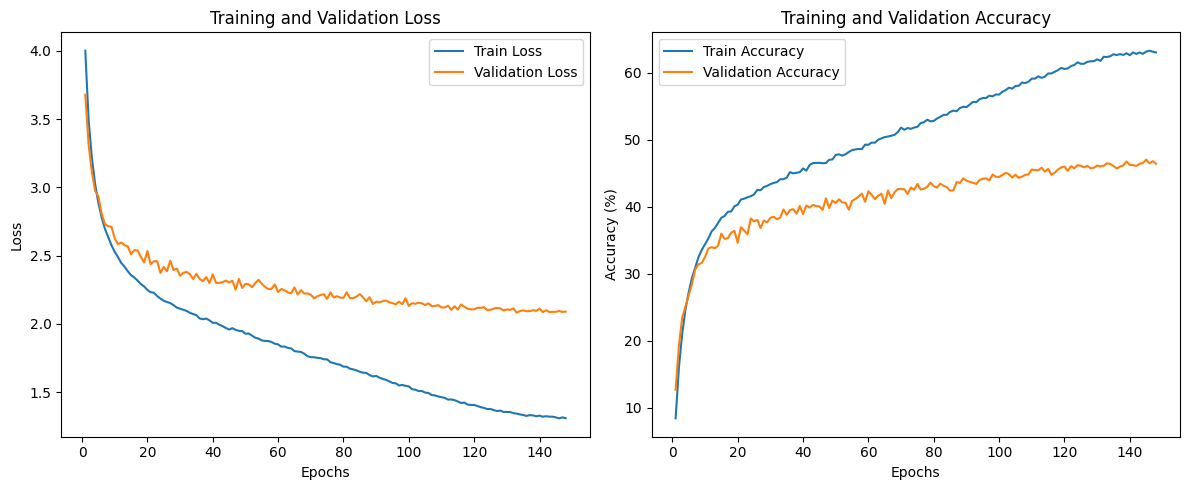

Training summary saved to Google Drive as 'training_summary.txt'


In [10]:
# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use the best hyperparameters from random search

    try:
        with open('/content/drive/MyDrive/best_hyperparams_AdamW.json', 'r') as f:    #best_hyperparams_AdamW.json or best_hyperparams_SGDM.json
            best_hyperparams = json.load(f)
    except FileNotFoundError:
        best_hyperparams = {
            'lr': 0.01,
            'weight_decay': 0.005,
            'momentum': 0.9,
            'patience': 100
        }

    print("\nUsing Best Hyperparameters from Random Search:", best_hyperparams)

    # Train with the best hyperparameters
    train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        best_hyperparams=best_hyperparams,
        num_epochs=150,
        device=device,
        checkpoint_path='/content/drive/MyDrive/checkpoint1.pth',
        type_of_optimizer="AdamW"  # AdamW or SGDM
    )

    # Plot results
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    # Save the plot before showing it
    save_path = '/content/drive/My Drive/Colab Notebooks/Traning_summary/Traning2'
    plt.savefig(save_path + 'training_results.png')
    print("Training results saved to Google Drive as 'training_results.png'")
    plt.show()

    # Save the summary
    with open(save_path + 'training_summary.txt', 'w') as f:
        f.write(f"Final Test Accuracy: {test_acc:.2f}%\n")
        f.write("Training and Validation Results:\n")
        f.write(f"Train Losses: {train_losses}\n")
        f.write(f"Validation Losses: {val_losses}\n")
        f.write(f"Train Accuracies: {train_accuracies}\n")
        f.write(f"Validation Accuracies: {val_accuracies}\n")

    print("Training summary saved to Google Drive as 'training_summary.txt'")
